# Prédiction de consommation électrique  avec `scikit-learn` 

Dans ce TP, nous allons étudier la consommation électrique en France métropole entre janvier 2016 et mai 2023, à partir des données provenant du réseau de transport d’électricité français (RTE), disponibles sur le site https://analysesetdonnees.rte-france.com/.

Le fichier `data/data.csv` (ou `data/data.pkl`) a été obtenu en agrégeant les données contenues dans les fichiers suivants : 
- `rte.csv` : consommation d'électricité relevée toutes les demi-heures
- `calendar.csv` : informations sur le temps
- `meteo.csv` : informations liées à la météo, notamment l'emplacement des stations et les différents relevés (température, nébulosité, humidité, vitesse du vent, précipitation), pris toutes les 3 heures. 

Pour les détails sur la génération de ce fichier, voir le notebook `day2_preparation_data.ipynb`.

# Import des données

Les données agrégées se trouvent dans le fichier `data/data.pkl`.

- Importer les données sous forme d'un `DataFrame` pandas que l'on nomme `data`
- Visualiser les premières et dernières lignes des données
- Afficher la taille du `DataFrame`
- Afficher les noms des premières 17 colonnes et ensuite des colonnes restantes
- Faire de même pour le type de données présentes dans ces colonnes
- Vérifier que le `DataFrame`ne contient pas de données manquantes
- Convertir les variables `Mois`, `Jour`, `JourFerieType` en variables dummies

### Solution

In [2]:
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None 
pd.options.display.float_format = '{:,.2f}'.format

path = 'data/'

data = pd.read_pickle(path + "data.pkl")

# A partir du .csv, il ne faut pas oublier de mettre la colonne DateTime au bon format
#data = pd.read_csv(path + "data.csv")
#data['DateTime'] = pd.to_datetime(data['DateTime']) 

In [3]:
data.head()

,DateTime,Consommation,Temperature,Nebulosity,Humidity,WindSpeed,Precipitation,PositionDansAnnee,Mois,DemiHeure,...,Precipitation PTE DE CHASSIRON,Precipitation PTE DE LA HAGUE,Precipitation RENNES-ST JACQUES,Precipitation ROUEN-BOOS,Precipitation ST GIRONS,Precipitation STRASBOURG-ENTZHEIM,Precipitation TARBES-OSSUN,Precipitation TOULOUSE-BLAGNAC,Precipitation TOURS,Precipitation TROYES-BARBEREY
0,2016-01-01 00:00:00+00:00,"60,165.00",6.70,88.76,91.34,2.29,-0.01,0.00,janvier,0,...,-0.10,0.00,0.00,-0.10,0.00,-0.10,0.00,0.00,0.00,0.00
1,2016-01-01 00:30:00+00:00,"58,887.00",6.54,88.47,91.63,2.24,-0.01,0.00,janvier,1,...,-0.08,0.00,0.00,-0.08,0.00,-0.08,0.00,0.00,0.00,0.03
2,2016-01-01 01:00:00+00:00,"56,678.00",6.38,88.19,91.91,2.20,-0.01,0.00,janvier,2,...,-0.07,0.00,0.00,-0.07,0.00,-0.07,0.00,0.00,0.00,0.07
3,2016-01-01 01:30:00+00:00,"56,460.00",6.22,87.90,92.20,2.15,-0.00,0.00,janvier,3,...,-0.05,0.00,0.00,-0.05,0.00,-0.05,0.00,0.00,0.00,0.10
4,2016-01-01 02:00:00+00:00,"55,780.00",6.06,87.61,92.48,2.11,-0.00,0.00,janvier,4,...,-0.03,0.00,0.00,-0.03,0.00,-0.03,0.00,0.00,0.00,0.13


In [4]:
data.tail()

,DateTime,Consommation,Temperature,Nebulosity,Humidity,WindSpeed,Precipitation,PositionDansAnnee,Mois,DemiHeure,...,Precipitation PTE DE CHASSIRON,Precipitation PTE DE LA HAGUE,Precipitation RENNES-ST JACQUES,Precipitation ROUEN-BOOS,Precipitation ST GIRONS,Precipitation STRASBOURG-ENTZHEIM,Precipitation TARBES-OSSUN,Precipitation TOULOUSE-BLAGNAC,Precipitation TOURS,Precipitation TROYES-BARBEREY
129979,2023-05-31 21:30:00+00:00,"41,786.00",17.04,72.50,73.53,3.24,0.32,0.41,mai,43,...,0.00,0.00,0.00,0.00,0.20,0.00,4.20,1.60,0.00,0.00
129980,2023-05-31 22:00:00+00:00,"42,076.00",17.04,72.50,73.53,3.24,0.32,0.41,mai,44,...,0.00,0.00,0.00,0.00,0.20,0.00,4.20,1.60,0.00,0.00
129981,2023-05-31 22:30:00+00:00,"42,402.00",17.04,72.50,73.53,3.24,0.32,0.41,mai,45,...,0.00,0.00,0.00,0.00,0.20,0.00,4.20,1.60,0.00,0.00
129982,2023-05-31 23:00:00+00:00,"43,211.00",17.04,72.50,73.53,3.24,0.32,0.41,mai,46,...,0.00,0.00,0.00,0.00,0.20,0.00,4.20,1.60,0.00,0.00
129983,2023-05-31 23:30:00+00:00,"42,279.00",17.04,72.50,73.53,3.24,0.32,0.41,mai,47,...,0.00,0.00,0.00,0.00,0.20,0.00,4.20,1.60,0.00,0.00


In [5]:
data.shape

(129984, 207)

In [6]:
print(data.columns[:17])
print(data.columns[17:])

Index(['DateTime', 'Consommation', 'Temperature', 'Nebulosity', 'Humidity',
       'WindSpeed', 'Precipitation', 'PositionDansAnnee', 'Mois', 'DemiHeure',
       'Jour', 'JourFerie', 'JourFerieType', 'Vacances', 'MJour', 'Annee',
       'is.2020'],
      dtype='object')
Index(['Temperature ABBEVILLE', 'Temperature ALENCON',
       'Temperature BALE-MULHOUSE', 'Temperature BELLE ILE-LE TALUT',
       'Temperature BORDEAUX-MERIGNAC', 'Temperature BOURGES',
       'Temperature BREST-GUIPAVAS', 'Temperature CAEN-CARPIQUET',
       'Temperature CAP CEPET', 'Temperature CLERMONT-FD',
       ...
       'Precipitation PTE DE CHASSIRON', 'Precipitation PTE DE LA HAGUE',
       'Precipitation RENNES-ST JACQUES', 'Precipitation ROUEN-BOOS',
       'Precipitation ST GIRONS', 'Precipitation STRASBOURG-ENTZHEIM',
       'Precipitation TARBES-OSSUN', 'Precipitation TOULOUSE-BLAGNAC',
       'Precipitation TOURS', 'Precipitation TROYES-BARBEREY'],
      dtype='object', length=190)


In [7]:
print(data[data.columns[:17]].dtypes)
print(data[data.columns[17:]].dtypes)

DateTime             datetime64[ns, UTC]
Consommation                     float64
Temperature                      float64
Nebulosity                       float64
Humidity                         float64
WindSpeed                        float64
Precipitation                    float64
PositionDansAnnee                float64
Mois                              object
DemiHeure                          int64
Jour                              object
JourFerie                          int64
JourFerieType                     object
Vacances                           int64
MJour                              int32
Annee                              int32
is.2020                             bool
dtype: object
Temperature ABBEVILLE                float64
Temperature ALENCON                  float64
Temperature BALE-MULHOUSE            float64
Temperature BELLE ILE-LE TALUT       float64
Temperature BORDEAUX-MERIGNAC        float64
                                      ...   
Precipitation STRAS

In [8]:
data[data.columns[:17]].describe()

,Consommation,Temperature,Nebulosity,Humidity,WindSpeed,Precipitation,PositionDansAnnee,DemiHeure,JourFerie,Vacances,MJour,Annee
count,"129,984.00","129,984.00","129,984.00","129,984.00","129,984.00","129,984.00","129,984.00","129,984.00","129,984.00","129,984.00","129,984.00","129,984.00"
mean,"53,169.35",12.88,79.35,74.99,3.79,0.24,0.48,23.50,0.03,1.02,15.72,"2,019.22"
std,"11,784.24",6.64,18.66,12.64,1.34,0.37,0.29,13.85,0.17,1.30,8.80,2.15
min,"29,053.00",-6.45,0.00,24.03,1.14,-0.03,0.00,0.00,0.00,0.00,1.00,"2,016.00"
25%,"44,178.75",7.84,73.25,67.21,2.80,0.00,0.23,11.75,0.00,0.00,8.00,"2,017.00"
50%,"51,366.00",12.26,86.09,78.03,3.54,0.07,0.47,23.50,0.00,0.00,16.00,"2,019.00"
75%,"61,285.00",17.67,92.06,84.89,4.55,0.32,0.74,35.25,0.00,3.00,23.00,"2,021.00"
max,"96,272.00",36.28,100.35,95.78,10.45,3.53,1.00,47.00,1.00,3.00,31.00,"2,023.00"


In [9]:
data.isnull().values.any()

False

In [10]:
moisCol = pd.get_dummies(data[['Mois']])
jourCol = pd.get_dummies(data[['Jour']])
jourFerieTypeCol = pd.get_dummies(data[['JourFerieType']])

In [11]:
data_with_dummies = pd.concat([data.drop(columns=['Mois', 'Jour', 'JourFerieType']), moisCol, jourCol, jourFerieTypeCol], axis=1)

# Analyse des données

Observons le tableau `data` des données agregées.

## Saisonnalité

Afficher le graphe des consommations éléctriques en fonction du temps. Observez-vous une saisonnalité ? 

### Solution

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

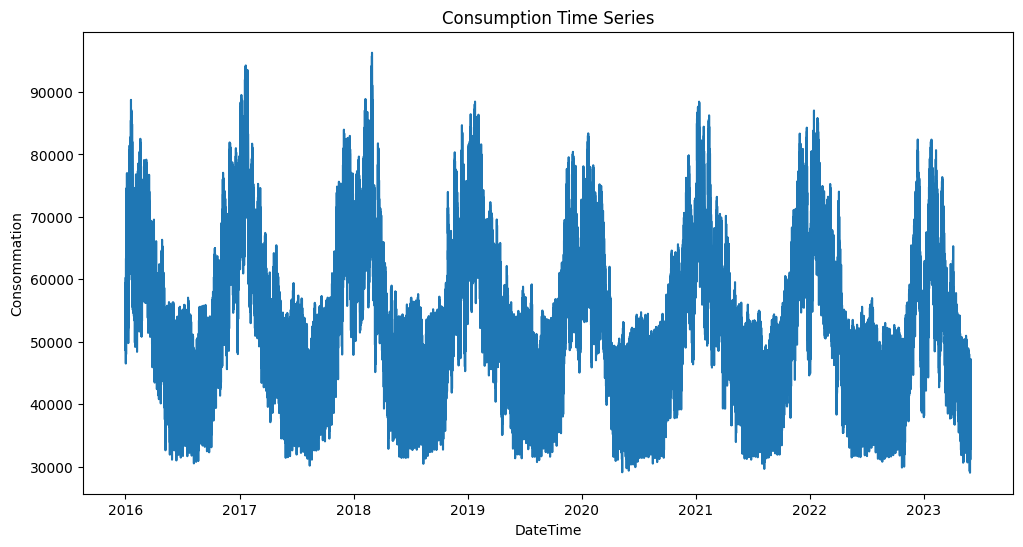

In [13]:
## Descriptive Analysis

# Plot the consumption time series
plt.figure(figsize=(12, 6))
plt.plot(data["DateTime"], data["Consommation"])
plt.xlabel("DateTime")
plt.ylabel("Consommation")
plt.title("Consumption Time Series")
plt.show()


On remarque une saisonnalité, avec des plus fortes consommations en hiver et plus faibles en été, et une baisse des consommations, par rapport à la moyenne saisonnière, lors du printemps 2020.

## Profils de consommation

Utiliser les fonctions `groupby` et `agg` de pandas pour regrouper les données en faisant la moyenne des consommations par mois, par jour, ou par demi-heure, de sorte à obtenir des profils de consommation annuel, hebdomadaire et journalier.

Afficher ces différents profils à l'aide de la fonction `lineplot` de la librairie `seaborn` et les commenter.

### Solution

#### Profil de consommation annuel

La moyenne des consommations à l'échelle des années montre des plus fortes consommations pendant les mois d'hiver et plus faibles pendant l'été.

In [21]:
monthly_avg

,DemiHeure,Mois,MJour,Consommation,DateTime
0,0,août,1,"44,280.14",2016-08-01 00:00:00+00:00
1,0,août,2,"44,335.29",2016-08-02 00:00:00+00:00
2,0,août,3,"44,717.43",2016-08-03 00:00:00+00:00
3,0,août,4,"44,432.14",2016-08-04 00:00:00+00:00
4,0,août,5,"43,720.14",2016-08-05 00:00:00+00:00
...,...,...,...,...,...
17563,47,septembre,26,"46,268.57",2016-09-26 23:30:00+00:00
17564,47,septembre,27,"46,870.71",2016-09-27 23:30:00+00:00
17565,47,septembre,28,"47,083.00",2016-09-28 23:30:00+00:00
17566,47,septembre,29,"46,719.00",2016-09-29 23:30:00+00:00


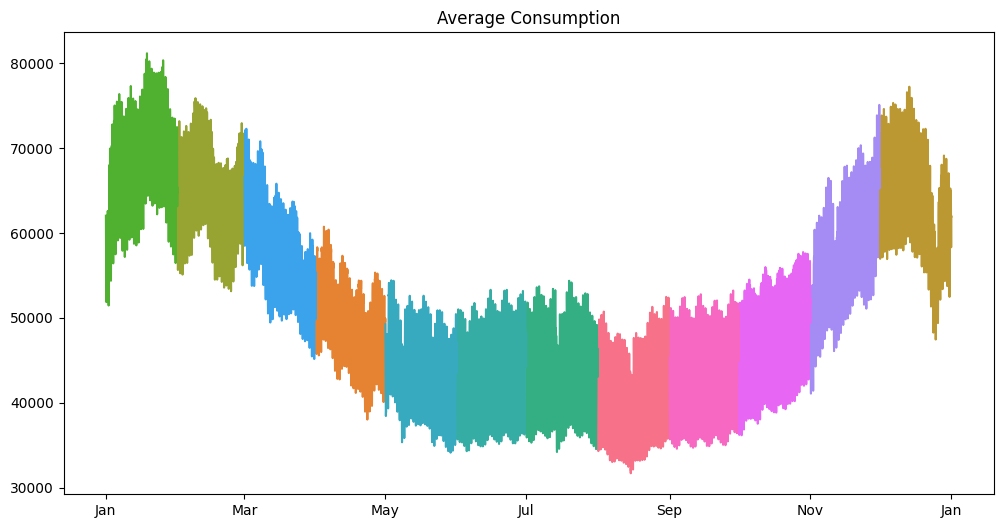

In [14]:
# Plot the annual average consumption 
monthly_avg = data.groupby(["DemiHeure", "Mois", "MJour"]).agg(Consommation=("Consommation", "mean"), DateTime =("DateTime" ,"first")).reset_index()
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x="DateTime", y="Consommation", data=monthly_avg, hue="Mois", legend=False) 
plt.xlabel("") 
plt.ylabel("")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.title("Average Consumption")
plt.show()

#### Profil de consommation hebdomadaire

La moyenne des consommations sur les semaines montre un consommation similaire les jours ouvrés et une baisse des consommation les jours fériés.

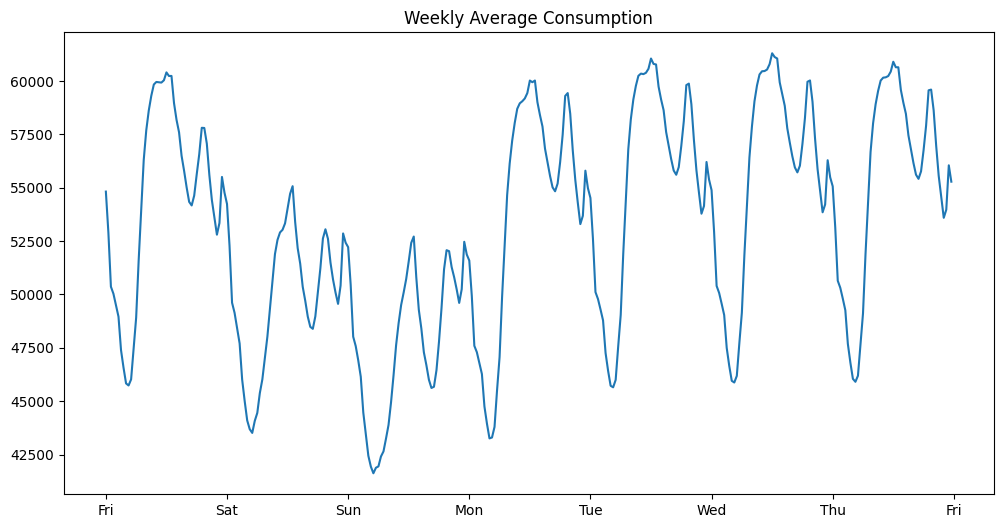

In [22]:
# Plot the Weekly average consumption
weekly_avg = data.groupby(["DemiHeure", "Jour"]).agg(Consommation=("Consommation", "mean"), DateTime =("DateTime" ,"first")).reset_index()
plt.figure(figsize=(12, 6))
ax =  sns.lineplot(x="DateTime", y="Consommation", data=weekly_avg)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))
plt.xlabel("")
plt.ylabel("")
plt.title("Weekly Average Consumption")
plt.show()

### Profil de consommation journalier

Les consommations journalières ont un creux entre 4h et 5h, montent jusqu'à un premier pic autour de midi, un deuxième entre 19h et 20H et un petit pic vers 22h.

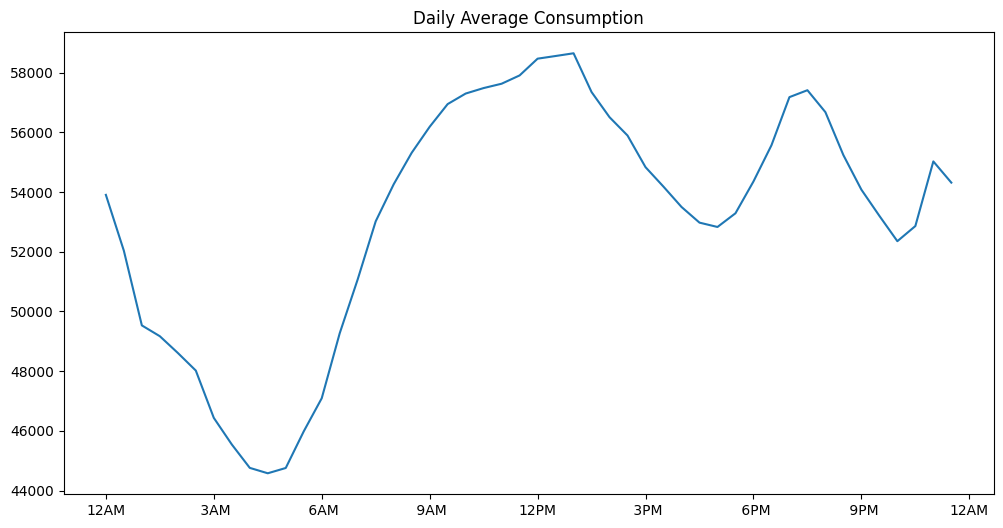

In [27]:
# Plot the Daily average consumption
daily_avg = data.groupby(["DemiHeure"]).agg(Consommation=("Consommation", "mean"), DateTime =("DateTime" ,"first")).reset_index()
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x="DateTime", y="Consommation", data=daily_avg)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%l%p'))
plt.xlabel("")
plt.ylabel("")
plt.title("Daily Average Consumption")
plt.show()

## Comportements particuliers

Il est possible de mettre en évidence des petites anomalies dues au jours fériés ou au printemps 2020. 

- Afficher la consommation du mois de mai 2017, en mettant en évidence les jours féries
- Afficher le profil de consommation journalier par jour de la semaine
- Comparer la consommation moyenne de l'année 2020 à celle du reste des données et affi

### Solution

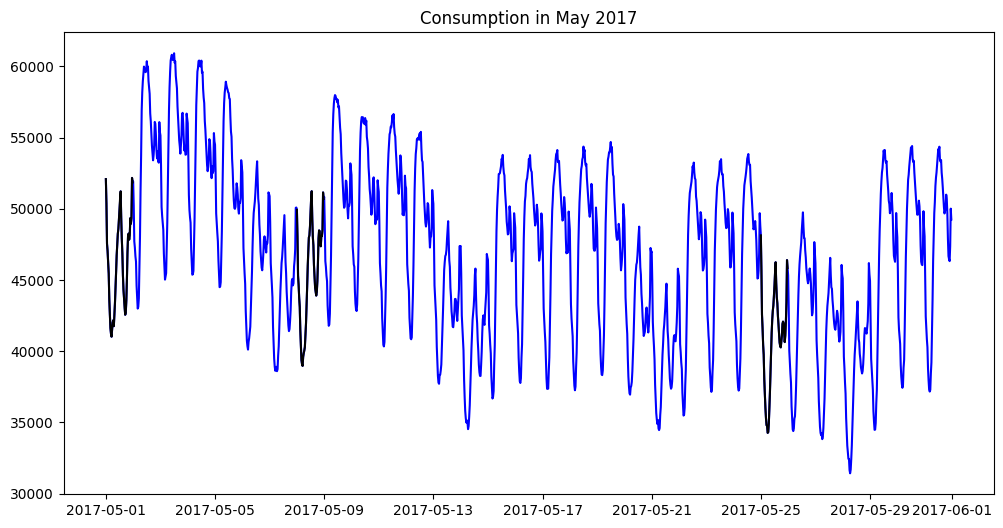

In [28]:
# Plot the consumption for May 2017
may_2017_data = data[(data['Annee'] == 2017) & (data['Mois'] == 'mai')]
may_2017_ferie = may_2017_data[may_2017_data['JourFerie'] == 1]
may_2017_ferie['MJour'].unique()

plt.figure(figsize=(12, 6))
plt.plot(may_2017_data['DateTime'], may_2017_data['Consommation'], color='blue')
for i in may_2017_ferie['MJour'].unique():
    plt.plot(may_2017_ferie[may_2017_ferie['MJour'] == i]['DateTime'], may_2017_ferie[may_2017_ferie['MJour'] == i]['Consommation'], color='black')
plt.xlabel('')
plt.ylabel('')
plt.title('Consumption in May 2017')
plt.show()

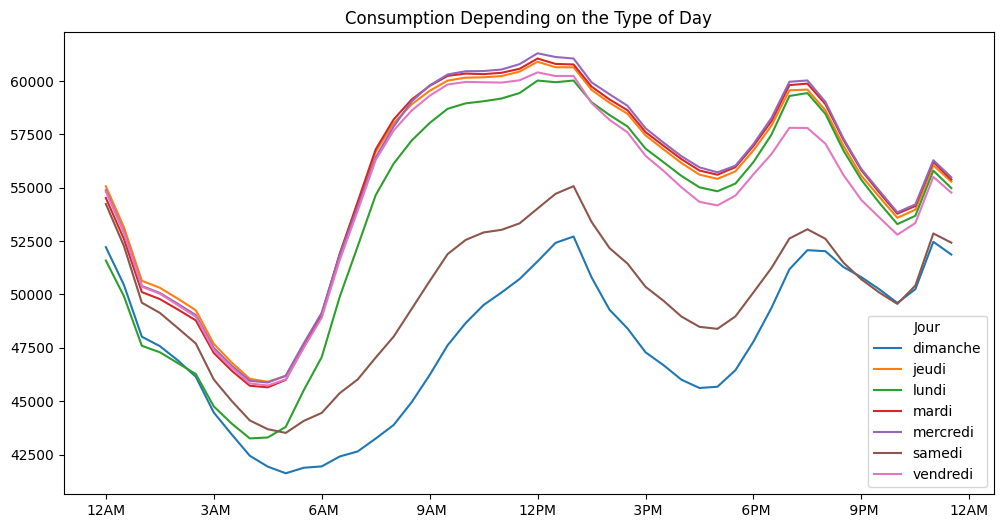

In [29]:
# Observe the consumption depending on the type of day
viz = data.groupby(["DemiHeure", "Jour"]).agg(Consommation=("Consommation", "mean"), DateTime =("DateTime" ,"first")).reset_index()
viz['DateTime'] = viz['DateTime'].apply(lambda x: x.replace(day=1))


plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='DateTime', y='Consommation', hue='Jour', data=viz)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%l%p'))
plt.xlabel('')
plt.ylabel('')
plt.title('Consumption Depending on the Type of Day')
plt.show()

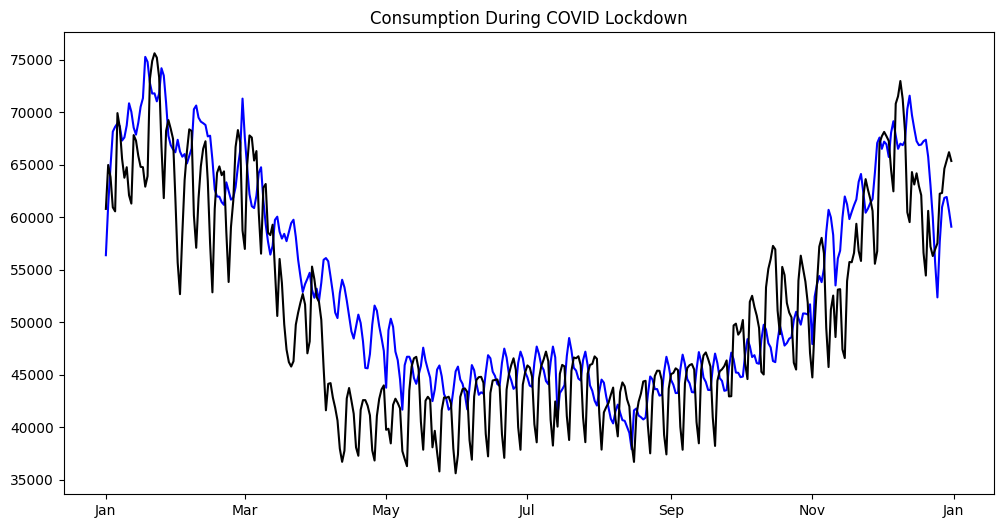

In [30]:
# Observe the consumption during the COVID lockdown
data_grouped_2020 = data.groupby(['is.2020', "MJour","Mois"]).agg(Consommation=("Consommation", "mean"), DateTime =("DateTime" ,"first")).reset_index()

data_grouped_2020['DateTime'] = data_grouped_2020['DateTime'].apply(lambda x: x.replace(year=2000))

plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='DateTime', y='Consommation', hue='is.2020', data=data_grouped_2020, palette=['blue', 'black'], legend=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Consumption During COVID Lockdown')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()

# Modèles : entraînement, prédiction et erreur 

## Séparation du jeu de données en train et test

Séparer le jeu de données en deux pour obtenir le jeu d'entraînement et le jeu de test tels que 

- `X_train` et `Y_train` contiennent 50% du jeu de données pour l'apprentissage du modèle  
- `X_test` et `Y_test` contiennent les 50% restants pour le test.

On pourra utiliser la  fonction `train_test_split` du module `sklearn.model_selection`.

### Solution

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_with_dummies.drop(columns=['DateTime', 'Consommation']), data_with_dummies['Consommation'], test_size=0.5, random_state=999)

In [39]:
X_train

,Temperature,Nebulosity,Humidity,WindSpeed,Precipitation,PositionDansAnnee,DemiHeure,JourFerie,Vacances,MJour,...,JourFerieType_15aout,JourFerieType_1janvier,JourFerieType_1mai,JourFerieType_1novembre,JourFerieType_25decembre,JourFerieType_8mai,JourFerieType_ascension,JourFerieType_nonFerie,JourFerieType_paques,JourFerieType_pentecote
10870,26.24,32.97,48.05,2.98,0.00,0.62,22,0,3,14,...,False,False,False,False,False,False,False,True,False,False
62722,21.47,85.67,59.55,6.26,0.20,0.58,34,0,3,30,...,False,False,False,False,False,False,False,True,False,False
122157,10.88,96.54,82.53,5.64,0.13,0.97,45,0,3,19,...,False,False,False,False,False,False,False,True,False,False
5671,4.15,74.24,78.47,1.93,-0.01,0.32,7,0,1,28,...,False,False,False,False,False,False,False,True,False,False
97682,16.77,89.18,89.59,2.94,0.92,0.57,2,0,3,28,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5832,11.51,67.78,54.39,6.32,0.01,0.33,24,1,1,1,...,False,False,True,False,False,False,False,False,False,False
82401,24.29,38.44,46.54,2.94,0.00,0.70,33,0,0,12,...,False,False,False,False,False,False,False,True,False,False
111461,12.89,52.17,83.81,2.43,0.02,0.36,5,0,0,11,...,False,False,False,False,False,False,False,True,False,False
78172,19.47,91.27,66.44,3.91,0.83,0.46,28,0,0,16,...,False,False,False,False,False,False,False,True,False,False


## Naive predictor

Construire un prédicteur naïf qui renvoie la moyenne des consommations (une constante) et calculer l'erreur MAPE et l'erreur RMSE de ce prédicteur sur le jeu de test et sur celui de train.

Ce prédicteur trivial représente le point de départ pour comparer les autres modèles.

- Stocker les erreurs MAPE et RMSE sur le jeu de train et le jeu de test du modèle naïf dans un DataFrame `df_errors`.

Pour rappel, si $\hat Y_t$ est la valeur prédite par le modèle et $Y_t$ la consommation réalisée :

MAPE = **mean absolute percentage error** : c'est une erreur de prédiction *relative*:
$${\displaystyle {\mbox{MAPE}}={\frac {1}{n}}\sum _{t=1}^{n}\left|{\frac {Y_{t}-\hat Y_{t}}{Y_{t}}}\right|}
$$
En pratique, on préfère diviser par $|Y_{t}+\varepsilon|$ pour éviter des division par zéro.

RMSE = **root mean squared error** : c'est une erreur de prédiction *absolue*, sensible aux outliers:
$${\displaystyle {\mbox{RMSE}}=\sqrt{\frac 1 n \sum _{t=1}^{n}\left(Y_{t}-\hat Y_{t}\right)^2}}
$$

On pourra utiliser les fonctions `mean_absolute_percentage_error` et `root_mean_squared_error` du module `sklearn.metrics`.

### Solution

In [33]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import root_mean_squared_error as rmse

In [36]:
# Naive predictor
predict_naive_test = np.repeat(Y_train.mean(),len(Y_test), axis = 0)
predict_naive_train = np.repeat(Y_train.mean(),len(Y_train), axis = 0)

mape_test = mape(Y_test, predict_naive_test)*100
mape_train = mape(Y_train, predict_naive_train)*100

rmse_test = rmse(Y_test, predict_naive_test)
rmse_train = rmse(Y_train, predict_naive_train)

print('On train set\n')
print(f'The MAPE in naive prediction with mean is {mape_train:.2f}%.')
print(f'The RMSE in naive prediction with mean is {rmse_train:.2f}.')
print('\nOn test set\n')
print(f'The MAPE in naive prediction with mean is {mape_test:.2f}%.')
print(f'The RMSE in naive prediction with mean is {rmse_test:.2f}.')

On train set

The MAPE in naive prediction with mean is 18.80%.
The RMSE in naive prediction with mean is 11760.80.

On test set

The MAPE in naive prediction with mean is 18.88%.
The RMSE in naive prediction with mean is 11807.62.


In [37]:
# stocker les résultats
d = {'Model': 'naive (mean)', 
     'MAPE test': mape_test, 
     'RMSE test': rmse_test, 
     'MAPE train': mape_train, 
     'RMSE train': rmse_train
     }
df_errors = pd.DataFrame(data=[d])
df_errors

,Model,MAPE test,RMSE test,MAPE train,RMSE train
0,naive (mean),18.88,"11,807.62",18.80,"11,760.80"


## Fonctions utiles

Tous les modèles de régression de la librairie scikit-learn ont une méthode `fit` qui permet d'entraîner le modèle et une méthode `predict` qui calcule la valeur prédite.

Nous allons comparer plusieurs méthodes et pour cela il sera utile de définir une fonction `fit_and_predict_error` qui, étant donné un modèle `model`, et un jeu de données `x_train`,`y_train`, `x_test`, `y_test`, entraîne le modèle en appelant la méthode `fit` du modèle sur le jeu d'entraînement, calcule la prédiction en appelant la méthode `predict` du modèle à la fois sur le jeu de test et sur le jeu de train, et calcule les erreurs MAPE et RMSE sur les 2 jeux.

Cette fonction renvoie un dictionnaire contenant les prédictions calculées, `train` et `test`, et les erreurs MAPE et RMSE pour les jeux de train et de test.

### Solution

In [ ]:
import time as tm

def fit_and_predict_error(model, x_train, y_train, x_test, y_test):
    start_time = tm.time()
    model.fit(x_train, y_train)
    predict_train = model.predict(x_train)
    predict_test = model.predict(x_test)
    end_time = tm.time()

    mape_test = mape(y_test, predict_test)*100
    rmse_test = rmse(y_test, predict_test)
    
    print('\nOn test set\n')
    print(f'The MAPE is {mape_test:.2f}%.')
    print(f'The RMSE is {rmse_test:.2f}.')
    
    return {'train' : predict_train, 'test' : predict_test, 
            'mape_train' : mape(y_train, predict_train)*100,
            'mape_test' : mape_test,
            'rmse_train' : rmse(y_train, predict_train), 
            'rmse_test' : rmse_test, 
            'time' : end_time-start_time}

Pour stocker l'information sur les erreurs dans le tableau des erreurs `df_errors`, nous définissons également une fonction qui permet de le faire rapidement. 

In [ ]:
def add_error(model_out, model_name, df):
    return df._append({'Model' : model_name, 
                  'MAPE test' : model_out['mape_test'], 
                  'RMSE test' : model_out['rmse_test'], 
                  'MAPE train' : model_out['mape_train'], 
                  'RMSE train' : model_out['rmse_train'], 
                  'CPU time' : model_out['time']}, ignore_index=True)

## Regression linéaire

Nous allons en première approche utiliser des modèles linéaires pour apprendre et prévoir les données de consommation.  

- A l'aide de la librairie `sklearn.linear_model`, mettre en place plusieurs modèles de regression linéaire pour prédire la variable `Consommation` en fonction des caractéristiques suivantes : 
    1. `Temperature`
    2. Données méteo
    3. Données méteo et `PositionDansAnnee`, `JourFerie`, `DemiHeure`
    4. Les caractéristiques ['Temperature', 'Nebulosity', 'Humidity', 'WindSpeed', 'Precipitation', 'PositionDansAnnee', 'DemiHeure', 'JourFerie',  'Vacances', 'MJour', 'Annee', 'is.2020']
    5. Toutes les caractéristiques

- Lequel de ces modèles donne les meilleurs résultats ? 

- Afficher, pour les modèles naïf, 1, 4 et 5, la consommation réelle et la consommation prédite sur les données complètes, sur un même graphe (il y a donc 4 graphes, un par modèle). 



### Solution

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
##### Model
linear_pipe = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=True))

# Model 1 : Linear regression on temperature
linear_temp = fit_and_predict_error(linear_pipe, X_train[['Temperature']], Y_train, X_test[['Temperature']], Y_test)
complete_linear_temp = linear_pipe.predict(data[['Temperature']])
df_errors = add_error(linear_temp, 'Linear on Temperature', df_errors)

# Model 2 : Linear regression on meteo features
meteo_features = ['Temperature', 'Nebulosity', 'Humidity', 'WindSpeed', 'Precipitation']
linear_meteo = fit_and_predict_error(linear_pipe, X_train[meteo_features], Y_train, X_test[meteo_features], Y_test)
complete_linear_meteo = linear_pipe.predict(data[meteo_features])
df_errors = add_error(linear_meteo, 'Linear on Meteo', df_errors)

# Model 3 : Linear regression on meteo features and calendar
meteo_cal_features = ['Temperature', 'Nebulosity', 'Humidity', 'WindSpeed', 'Precipitation','PositionDansAnnee', 'JourFerie', 'DemiHeure']
linear_meteo_cal = fit_and_predict_error(linear_pipe, X_train[meteo_cal_features], Y_train, X_test[meteo_cal_features], Y_test)
complete_linear_meteo_cal = linear_pipe.predict(data[meteo_cal_features])
df_errors = add_error(linear_meteo_cal, 'Linear on Meteo and Cal', df_errors)

# Model 4 : Linear regression on small
features = ['Temperature', 'Nebulosity', 'Humidity', 'WindSpeed', 'Precipitation', 'PositionDansAnnee', 'DemiHeure', 'JourFerie',  'Vacances', 'MJour', 'Annee', 'is.2020']
linear_small = fit_and_predict_error(linear_pipe, X_train[features], Y_train, X_test[features], Y_test)
complete_linear_small = linear_pipe.predict(data[features])
df_errors = add_error(linear_small, 'Linear S', df_errors)

# Model 5 : Linear regression on large
linear_large = fit_and_predict_error(linear_pipe, X_train, Y_train, X_test, Y_test)
complete_linear_large = linear_pipe.predict(data_with_dummies.drop(columns = ['DateTime', 'Consommation']))
df_errors = add_error(linear_large, 'Linear L', df_errors)

In [ ]:
df_errors

In [ ]:
# On peut varier le mois du 01 au 04
time = data[data['DateTime'] > pd.Timestamp("2023-03-01 00:00", tz='UTC')]['DateTime']
index = data['Consommation'].size-time.size

fig, axs = plt.subplots(2,2, figsize=(12,8), sharey=True)
for ax in axs.flat:
    ax.plot(time, data[index:]['Consommation'], label='Consommation', color='blue') 
axs.flat[0].plot(time, np.repeat(Y_train.mean(),len(time), axis = 0), label='Prevision naive', color='black')
axs.flat[1].plot(time, complete_linear_temp[index:], label='Prevision temperature', color='red')
axs.flat[2].plot(time, complete_linear_small[index:], label='Prevision small', color='green')
axs.flat[3].plot(time, complete_linear_large[index:], label='Prevision large', color='orange')

for ax in axs.flat:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax.legend() 

fig.autofmt_xdate()
plt.suptitle("Linear regression")

plt.show()

Nous allons dorenavant travailler uniquement sur deux ensembles de caractéristiques :
- Les caractéristiques réduites  :  ['Temperature', 'Nebulosity', 'Humidity', 'WindSpeed', 'Precipitation', 'PositionDansAnnee', 'DemiHeure', 'JourFerie', 'Vacances', 'MJour', 'Annee', 'is.2020']
- Les caractéristiques complètes

Créer deux jeux de données d'entrainement (et de test) `X_train_S` et `X_train_L` (respectivement `X_test_S` et `X_test_L`) correspondants à ces deux ensembles.

### Solution 

In [ ]:
X_train_S = X_train[features]
X_train_L = X_train

X_test_S = X_test[features]
X_test_L = X_test

## Lasso and Ridge regression

Essayons d'améliorer les performances en ajoutant une pénalité $\ell_1$ et une pénalité $\ell_2$ à la regression linéaire. 

A l'aide des modules `LassoCV` et `RidgeCV` mettre en place deux estimateurs sur les données réduites et sur les données complètes.

### Solution

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV

# LASSO
#=========

# Model Small : Lasso regression on reduced data
lasso_pipe_S = make_pipeline(StandardScaler(), LassoCV())
lasso_small = fit_and_predict_error(lasso_pipe_S, X_train_S, Y_train, X_test_S, Y_test)
df_errors = add_error(lasso_small, 'Lasso S', df_errors)

# Model Large : Lasso regression on complete data
lasso_pipe_L = make_pipeline(StandardScaler(), LassoCV())
lasso_large = fit_and_predict_error(lasso_pipe_L, X_train_L, Y_train, X_test_L, Y_test)
df_errors = add_error(lasso_large, 'Lasso L', df_errors)

# RIDGE
#=========

# Model Small : Ridge regression on reduced data
ridge_pipe_S = make_pipeline(StandardScaler(), RidgeCV())
ridge_small = fit_and_predict_error(ridge_pipe_S, X_train_S, Y_train, X_test_S, Y_test)
df_errors = add_error(ridge_small, 'Ridge S', df_errors)

# Model Small : Ridge regression complete data
ridge_pipe_L = make_pipeline(StandardScaler(), RidgeCV())
ridge_large = fit_and_predict_error(ridge_pipe_L, X_train_L, Y_train, X_test_L, Y_test)
df_errors = add_error(ridge_large, 'Ridge L', df_errors)

In [ ]:
df_errors

In [ ]:
df_errors = df_errors.drop(index=[1,2,3,5,6,8,9])

In [ ]:
df_errors

## Arbres de décision -- CART

Les *Classification and Regression Trees* (CART) permettent de prédire la consommation en suivant des simples règles de décision qui dépendent des caractéristiques observées.

Le choix du nombres et du type de caractéristiques utilisées pour construire un arbre, ainsi que sa profondeur influent énormément sur le résultat, les paramètres à indiquer dans sa construction sont à choisir attentivement. 

A noter que dans un contexte d'arbres de décision la normalisation des caractéristiques n'est pas nécessaire.

### Exercice : Default

Utiliser la classe `DecisionTreeRegressor` du module `sklearn.tree` pour construire un estimateur basé sur un arbre de décision.

- Utiliser initialement les paramètres par défaut.

- Entraîner le modèle sur les données réduites et sur les données complètes.

- Afficher les erreurs. Que remarque-t-on sur les erreurs calculées sur le train set ? Comment le justifier ?

### Solution

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
cart_S = DecisionTreeRegressor()

cart_small = fit_and_predict_error(cart_S, X_train_S, Y_train, X_test_S, Y_test)
df_errors = add_error(cart_small, 'Default Cart S', df_errors)

In [ ]:
cart_L = DecisionTreeRegressor()

cart_large = fit_and_predict_error(cart_L, X_train_L, Y_train, X_test_L, Y_test)
df_errors = add_error(cart_large, 'Default Cart L', df_errors)

In [ ]:
df_errors

Dans l'appel à la documentation `?cart` on trouve la valeur par défaut

>max_depth : int, default=None
    The maximum depth of the tree. If None, then nodes are expanded until
    all leaves are pure or until all leaves contain less than
    min_samples_split samples.

qui signifie que l'arbre est développé jusqu'à quand toutes les feuilles sont pures. Donc sur le train la prédiction est exacte, car l'arbre permet de reconstruire exactement les consommation à partir des données. 

### Exercice : Réduction de profondeur

Retrouver dans la documentation les valeurs par défaut des paramètres d'un arbre de régression suivants :

- max_depth
- min_samples_leaf
- max_features
  
Quelle est la profondeur de l'arbre construit par défaut ? 

Construire un arbre de profondeur 10 et comparer les erreurs avec les modèles précédents.

### Solution

In [ ]:
print('Depth', cart_S.get_depth())  

feature_importance = cart_S.feature_importances_
sorted_idx = np.argsort(feature_importance)
X_train_S.columns[sorted_idx]

In [ ]:
cart = DecisionTreeRegressor(max_depth = 10)

In [ ]:
%%time
cart_10_small = fit_and_predict_error(cart, X_train_S, Y_train, X_test_S, Y_test)
df_errors = add_error(cart_10_small, 'Cart depth 10 S', df_errors)

In [ ]:
%%time
cart_10_large = fit_and_predict_error(cart, X_train_L, Y_train, X_test_L, Y_test)
df_errors = add_error(cart_10_large, 'Cart depth 10 L', df_errors)

In [ ]:
df_errors

In [ ]:
# Pourquoi l'arbre par défaut n'a pas un nombre de feuilles = len(X_train)? Pas parce qu'il y a des lignes pareilles.
np.sum(X_train_S.duplicated())
print('Number of leaves', cart_S.get_n_leaves())

### Exercice : Visualisation

- Construire un arbre de profondeur 4 et l'entraîner sur les données complètes
- A l'aide de la fonction `plot_tree` du module `tree` de sklearn, visualiser l'arbre de décision.

- Quelles sont les caractéristiques sur lesquelles sont fait les splits de cet arbre ? 
- Combien de noeuds a cet arbre ? Combien d'observations y a-t-il dans chaque noeud ? 

### Solution

In [ ]:
cart.max_depth = 4
cart.fit(X_train_L, Y_train)

from sklearn import tree

tree.plot_tree(cart, fontsize=10, feature_names=X_train_L.columns.values)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

In [ ]:
print(cart.tree_.n_node_samples) # nb d'observations dans chaque noeud
print(cart.tree_.node_count) # nb de noeuds

## Bagging

Le bagging (ou agrégation Bootstrap) est un type d'apprentissage d'ensemble dans lequel plusieurs modèles de base sont entrainés indépendamment et en parallèle sur différents sous-ensembles des données d'entraînement. Dans le bagging, les étapes d'entraînement et de prédiction sont précédées par une étape de bootstrap.

1. **Échantillonnage bootstrap** : Dans l'échantillonnage bootstrap, $K$ sous-ensembles aléatoires des données originales sont échantillonnés avec remplacement. Cette étape garantit que les modèles de base sont formés sur divers sous-ensembles des données, car certains échantillons peuvent apparaître plusieurs fois dans le nouveau sous-ensemble, tandis que d'autres peuvent être omis. Cela réduit les risques de surajustement et améliore la précision du modèle.

2. **Entraînement sur les modèles de base** : Après la première étape d'échantillonnage bootstrap, le modèle de base (arbres de décision, SVM...) est entraîné indépendamment sur chaque sous-ensemble de données bootstrap différent. Ces modèles de base sont généralement dits « faibles » car ils peuvent ne pas être très précis à eux seuls. 

3. **Agrégation** : Une fois que tous les modèles de base ont été entraînés, ils sont utilisé pour faire chacun une prédiction sur les données de test. Dans les modèles de classification, la prédiction finale est effectuée en agrégeant les prédictions des modèles de base en utilisant le vote majoritaire. Dans les modèles de régression, la prédiction finale est obtenue en faisant la moyenne des prédictions des modèles de base.

**Évaluation Out-of-Bag (OOB)** : Dans l'étape d'échantillonage, certaines observations sont exclues de l'échantillon boostrap. Ces observations *out-of-bag* peuvent être utilisées pour évaluer les performances du modèle.

![Classificateur par agrégation bootstrap](img/Bagging-classifier.png)

Les arbres de décision vus au point précédent sont extrêmement dépendant du training set. Les modèles de bagging, grâce à l'étape d'échantillonnage aléatoire, permettent de réduire cette sensibilité aux données d'entraînement.


### Exercice : Bagging à la main

Ecrire un bagging à la main de taille `K=100` *sur les données réduites* en suivant les étapes suivantes :

1. Créer K échantillons boostrap de même taille que l'échantillon d'entraînement :
    - Utiliser la fonction `np.random.choice` avec paramètre `replace=True` pour générer un tableau d'indices `indexes` de même taille que l'échantillon original
    - Un échantillon booststrap est donné par `X_train_S.iloc[indexes]`
2. Entraîner un arbre de décision simple (peu profond, avec un nombre d'observations minimal par feuille, ...) sur chaque échantillon bootstrap
3. Calculer la valeur prédite par bagging :
      - Calculer la prédiction de chaque arbre
      - Renvoyer la moyenne des valeurs prédites par les K arbres
4. Calculer et afficher les erreurs MAPE et RMSE *out-of-bag*. 

Une fois le modèle sur les données réduites maîtrisé, il est possible de passer sur les données complètes, tout en tenant compte des temps de calculs attendus.

### Solution

In [ ]:
print('Temps attendu sur données réduites : ', 0.5*100/60, 'm')
print('Temps attendu sur données complètes : ', 7.5*100/60, 'm')

In [ ]:
# 100 Regression Trees on Bootstrap Samples
K = 100
n_train = len(X_train_S) # ou X_train_S.shape[0]
n_test = len(X_test_S) 
pred_train = np.zeros((n_train, K))
pred_test = np.zeros((n_test, K))
indexes = np.zeros((n_train, K))
pred_oob = []

cart.max_depth = 10

dict_train = {}
dict_oob = {}

for i in range(n_train):
    dict_train[i] = []
    dict_oob[i] = []

for k in range(K):
    indexes = np.random.choice(n_train, n_train, replace=True)
    cart.fit(X_train_S.iloc[indexes], Y_train.iloc[indexes])
    pred = cart.predict(X_train_S)
    
    for i in range(n_train):
        if i in indexes:
            dict_train[i].append(pred[i])
        else:
            dict_oob[i].append(pred[i])
    
    pred_test[:, k] = cart.predict(X_test_S)

pred_test_mean = pred_test.mean(axis = 1)

In [ ]:
pred_train_mean = np.array([np.mean(dict_train[i]) for i in range(n_train)]) # valeur prédite sur les données du train
pred_oob_mean = np.array([np.mean(dict_oob[i]) for i in range(n_train)]) # valeur prédite sur les données oob

print(mape(pred_oob_mean, Y_train)*100)
print(rmse(pred_oob_mean, Y_train))

In [ ]:
df_errors = df_errors._append({'Model' : 'Manual Bagging depth  10 S', 
                  'MAPE test' : mape(pred_test_mean, Y_test)*100, 
                  'RMSE test' : rmse(pred_test_mean, Y_test), 
                  'MAPE train' : mape(pred_train_mean, Y_train)*100, 
                  'RMSE train' : rmse(pred_train_mean, Y_train), }, ignore_index=True)

In [ ]:
df_errors

In [ ]:
df_errors = df_errors._append({'Model' : 'Manual Bagging depth  10 S', 
                  'MAPE test' : mape(pred_test_mean, Y_test)*100, 
                  'RMSE test' : rmse(pred_test_mean, Y_test), 
                  'MAPE train' : mape(pred_train_mean, Y_train)*100, 
                  'RMSE train' : rmse(pred_train_mean, Y_train), }, ignore_index=True)

In [ ]:
df_errors

### Exercice : Bagging de sklearn

- Comparer avec un bagging construit en utilisant la fonction `BaggingRegressor` du module `sklearn.ensemble`.
- Afficher le score *out-of-bag* de ce prédicteur.

### Solution

In [ ]:
from sklearn.ensemble import BaggingRegressor

In [ ]:
#?BaggingRegressor

In [ ]:
cart = DecisionTreeRegressor(max_depth=10)
bagging_S = BaggingRegressor(estimator=cart, oob_score=True, n_estimators=100)

bagging_small = fit_and_predict_error(bagging_S, X_train_S, Y_train, X_test_S, Y_test)
df_errors = add_error(bagging_small, 'Bagging Cart depth 10 S', df_errors)

bagging_L = BaggingRegressor(estimator=cart, oob_score=True, n_estimators=100)
bagging_large = fit_and_predict_error(bagging_L, X_train_L, Y_train, X_test_L, Y_test)
df_errors = add_error(cart_large, 'Bagging Cart depth 10 L', df_errors)

In [ ]:
df_errors

In [ ]:
print(bagging_S.oob_score_)
print(bagging_L.oob_score_)

### Random forest

Le forêts aléatoires sont une extension du bagging pour les arbres de décision qui permet de réduire davantage la variance du modèle, en ajoutant un caractère aléatoire lors de la création des arbres.

Pendant la construction d'un arbre, au lieu de rechercher la caractéristique la plus importante lors de la division d'un nœud, on recherche la meilleure caractéristique **parmi un sous-ensemble aléatoire de caractéristiques**. Il y a donc deux niveaux *random* dans ce modèle (d'où le nom "random forest"): le random du bootstrap et la sélection random des caractéristiques. Le premier réduit la dépendance au training set, le deuxième réduit la corrélation entre les arbres de la forêt. Il en résulte une grande diversité qui se traduit généralement par un meilleur modèle.

### Exercice

- A l'aide de la classe `RandomForestRegressor` du module `sklearn.ensemble`, entraîner une foret aléatoire avec paramètres par défaut sur les données réduites et comparer les erreurs avec les autres modèles. Afficher également le score *out-of-bag* de ce prédicteur.  
- Visualiser dans un graphe l'évolution des erreurs en fonction du nombre d'arbres de la forêt.
- Les résultats théoriques montrent que le bon nombre de caractéristiques à tenir en compte lors d'un split est soit de l'ordre de la racine carré du nombre total des caractéristiques, soit de son logarithme. Entraîner une foret aléatoire avec un nombre d'arbres choisi sur la base de la visualisation du point précédent, et un nombre de caractéristiques de l'ordre de la racine carré du nombre total de caractéristiques. Afficher également le score *out-of-bag* de ce prédicteur.  

  

### Solution

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(oob_score=True)

rf_small = fit_and_predict_error(rf, X_train_S, Y_train, X_test_S, Y_test)   
df_errors = add_error(rf_small, 'Default Random Forest S', df_errors)

df_errors

In [ ]:
rf.oob_score_

In [ ]:
K = rf.n_estimators
prev_test = np.zeros((len(X_test_S), K))
errEvol = np.zeros(K)
for k in range(K):
    prev_test[:, k] = rf.estimators_[k].predict(X_test_S.values)
    pred_mean_k = prev_test[:, : (k+1)].mean(axis = 1)
    errEvol[k] = mape(Y_test, pred_mean_k)
plt.plot(errEvol)

In [ ]:
rf_S = RandomForestRegressor(max_features= "sqrt", n_estimators=60, oob_score=True)

rf_small = fit_and_predict_error(rf_S, X_train_S, Y_train, X_test_S, Y_test)
df_errors = add_error(rf_small, 'Random Forest 60 sqrt S', df_errors)

df_errors

In [ ]:
rf.oob_score_

In [ ]:
rf_L = RandomForestRegressor(max_features= "sqrt", n_estimators=60, oob_score=True)

rf_large = fit_and_predict_error(rf_L, X_train_L, Y_train, X_test_L, Y_test)
df_errors = add_error(rf_large, 'Random Forest 60 sqrt L', df_errors)

df_errors

### Extra trees

Proche des forêts aléatoires, les Extra Trees, dit aussi Extremely Randomized Trees, ajoutent une couche supplémentaire d'aléatoire au forêts, en choisissant le split d'une caractéristique au hasard, au lieu qu'en sélectionnant le meilleur split. Cela réduit par ailleurs de façon considérable le temps de calcul.

### Exercice

- Combiner la classe `ExtraTreeRegressor` et `BaggingRegressor` pour obtenir une forêt d'arbres extrêmement aléatoires.  
- Entraîner, prédire et afficher le score *out-of-bag* d'abord sur les données réduites, et ensuite sur les données complètes.

### Solution

In [ ]:
from sklearn.tree import ExtraTreeRegressor

# n_estimators=10 par défaut, on l'augmente pour avoir un estimateur satisfaisant
extra_tree_S = ExtraTreeRegressor()
bagging_xtree_S = BaggingRegressor(extra_tree_S, oob_score=True, n_estimators=100)

extra_small = fit_and_predict_error(bagging_xtree_S, X_train_S, Y_train, X_test_S, Y_test)
df_errors = add_error(extra_small, 'Extra Tree S', df_errors)

df_errors  

In [ ]:
bagging_xtree_S.oob_score_

In [ ]:
extra_tree_L = ExtraTreeRegressor()
bagging_xtree_L = BaggingRegressor(extra_tree_L, oob_score=True, n_estimators=100)

extra_large = fit_and_predict_error(bagging_xtree_L, X_train_L, Y_train, X_test_L, Y_test)
df_errors = add_error(extra_large, 'Extra Tree L', df_errors)

df_errors  

In [ ]:
bagging_xtree_L.oob_score_

## Boosting

Nous avons vu que les méthodes de Bagging permettent de construire un prédicteur robuste à partir de plusieurs prédicteurs faibles. Les prédicteurs faibles peuvent être construits en parallèle, c'est-à-dire que la construction de chacun d'entre eux peut être faite indépendamment des autres.

Une autre technique d'ensemble, différente du Bagging, consiste à générer les prédicteurs de façon séquentielle, en améliorant à chaque itération le nouveau modèle par rapport au précédent. C'est la technique du **Boosting**.

Tout d'abord, un modèle est construit à partir des données d'apprentissage. Ensuite, un deuxième modèle est construit pour tenter de corriger les erreurs présentes dans le premier modèle. Cette procédure se poursuit et des modèles sont ajoutés jusqu'à ce que l'ensemble des données d'apprentissage soit prédit correctement ou que le nombre maximum de modèles soit atteint. 

Dans toutes les techniques de Boosting, des poids sont associés aux données d'apprentissage, et à chaque itération ces poids sont réajustés, de façon à augmenter le poids des données mal prédites  et réduire celui des données correctement prédites. Ceci permet au modèle suivant de se "concentrer" sur les mauvaise prédictions et de s'améliorer.

![Boosting classifier](img/Boosting-classifier.png)

Il existe plusieurs algorithmes de Boosting, parmi les plus connus nous pouvons citer : 
- **Gradient Boosting** :
    - Chaque nouveau modèle est entraîné pour minimiser la fonction de perte (erreur quadratique moyenne ou cross-entropie) du modèle précédent à l'aide d'une descente de gradient.
    - À chaque itération, l'algorithme calcule le gradient de la fonction de perte par rapport aux prédictions de l'ensemble actuel, puis entraîne un nouveau modèle faible pour minimiser ce gradient.
    - Les prédictions du nouveau modèle sont ensuite ajoutées à l'ensemble, et le processus est répété jusqu'à ce qu'un critère d'arrêt soit rempli.
- **AdaBoost** -- Adaptative Boosting :
    - Attribue des poids aux observations et aux modèles faibles
    - A chaque itération, augmente le poids des observations mal classés par le modèle précédent et diminue le poids de celles bien classés, pour se "concentrer" sur les mauvaises et s'améliorer. Une note/poids est donné à chaque modèle, pour que ceux qui ont les meilleures performances soient plus écoutés lors de l'étape finale d'aggrégation.  
- **XGBoost** -- eXtreme Gradient Boosting :
    - Version améliorée de Gradient Boosting, qui ne conserve que des bons modèles faibles

### Exercice

Utiliser le module `GradientBoostingRegressor` pour prédire la consommation via une regression par Gradient Boosting avec un learning rate égal à 0.7, un nombre d'estimateurs égal à 100 et une profondeur de l'arbre égale à 10. 

Si vous en avez le temps, faites de la validation croisée sur le learning rate et le nombre d'estimateurs.


### Solution

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(learning_rate=0.7, n_estimators=100,max_depth=10)

gb_small = fit_and_predict_error(gb, X_train_S, Y_train, X_test_S, Y_test)
df_errors = add_error(gb_small, 'Gradient Boosting S n=100', df_errors)

df_errors

In [ ]:
gb = GradientBoostingRegressor(learning_rate=0.7, n_estimators=100,max_depth=10)

gb_large = fit_and_predict_error(gb, X_train_L, Y_train, X_test_L, Y_test)
df_errors = add_error(gb_large, 'Gradient Boosting L n=100', df_errors)

df_errors

## Feature importance/importance des variables

L'importance des variables indique dans quelle mesure chaque caractéristique contribue à la prédiction du modèle. Une première idée de l'importance des variables, par exemple, peut être donnée par la correlation entre chaque variable et la variable à prédire. Selon le modèle, il existe d'autres mesures qui peuvent aider à affiner la compréhension de quelles variables contribuent le plus à la prédiction.

### Exercice : Regressions linéaires

Combien de caractéristiques sont retenues dans les modèles Lasso ? 

Commenter au vu des erreurs obtenues.

### Solution

In [ ]:
total_features_lasso_small = len(lasso_pipe_S.named_steps['lassocv'].coef_)
features_lasso_small =  total_features_lasso_small - np.sum(np.abs(lasso_pipe_S.named_steps['lassocv'].coef_) == 0) 

print("Total number of features of Lasso Small : ", total_features_lasso_small)
print("Retained features of Lasso Small : ", features_lasso_small)

total_features_lasso_large = len(lasso_pipe_L.named_steps['lassocv'].coef_)
features_lasso_large =  total_features_lasso_large - np.sum(np.abs(lasso_pipe_L.named_steps['lassocv'].coef_) == 0) 

print("Total number of features of Lasso Large : ", total_features_lasso_large)
print("Retained features of Lasso Large : ", features_lasso_large)

Le modèle de Lasso entraîné sur les données complètes affiche la même erreur que le modèle linéaire entraîné sur les mêmes données, alors qu'il utilise 44 caractéristiques en moins pour calculer la prédiction. Le modèle de Lasso est donc à préférer par rapport à une regression linéaire.

### Exercice : Modèles d'ensembles 
Pour les arbres de décisions, les forêts aléatoires ou le gradient boosting, l'importance d'une variable peut être calculée comme la réduction totale du critère apportée par cette variable. Cet indice est connu aussi sous le nom de indice de Gini.

Afficher dans un histogramme à barres horizontales (`barh`) l'indice de Gini des 10 variables le plus importantes.

### Solution

In [ ]:
# pour les bagging on peut récuperer les fi de chaque sous-modele
#bagging_xtree_L.estimators_[0].feature_importances_

models = [cart_S,rf_S,gb]

fig, axs = plt.subplots(len(models), figsize=(12,8), sharex=True)
for model,ax in zip(models,axs.flat):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    n_features = 10
    #n_features = sorted_idx.shape[0]
    pos = np.arange(n_features) + 0.5
    ax.barh(pos, feature_importance[sorted_idx][-n_features:], align="center")
    ax.set_yticks(pos, X_train_S.columns.values[sorted_idx][-n_features:])
    ax.set_title(f'{type(model).__name__ }')
plt.show()

In [ ]:
#df_errors.to_pickle(path + "day2_errors.pkl")
df_errors_S_L = pd.read_pickle(path + "day2_errors.pkl")
df_errors_S_L

# Approche LSTM

Le but est d'illustrer l'utilisation d'un réseau de neurones récurrents (RNN) pour la prédiction de la consommation. Pour simplifier on oublie les autres variables et on cherche une relation entre les consommations passées (sur une période de temps à définir) et la consommation à venir (ou les consommations). 

On note $(y_k)_{k = 1, \dots,n}$ la série des consommations aux instants $t_k$ (les différentes demi-heures). 

Fixons $\tau \ge 1$ une taille de fenêtre de temps et $k \ge \tau$. On cherche une relation entre la consommation $y_{k+1}$ à l'instant $t_{k+1}$ et les consommations passées $y_{k-\tau}, \dots, y_k$ c'est à dire construire une prédiction $\hat y_{k+1}$ comme fonction de $y_{k}, \dots, y_{k-\tau}$
\begin{equation*}
    \hat y_{k+1} = g^{(\tau)} \big( y_{k}, \dots, y_{k-\tau} \big).
\end{equation*}
L'idée d'un RNN est d'introduire un état caché $h$ vecteur de $\mathbf{R}^d$ et une fonction paramétrique $f_\theta$ tels que,
\begin{equation*}
    \forall j \ge {k-\tau}, \quad h_j = f_\theta\big(h_{j-1}, y_j \big), 
\end{equation*}
avec $h_{k-\tau-1}$ fixé, par exemple un vecteur nul. Si on "dérécursive" cette relation on obtient 
\begin{align*}
    h_{k-\tau} &= f_\theta\big(h_{k-\tau-1}, y_{k-\tau} \big) \\
    h_{k-\tau+1} &= f_\theta\big(f_\theta\big(h_{k-\tau-1}, y_{k-\tau} \big), y_{k-\tau+1} \big) \\
    &\dots \\
    h_k & = f_\theta\big(f_\theta\big(\dots, y_{k-1} \big), y_{k} \big)
\end{align*}
Ainsi $h_k$ est une fonction de $\big(y_{k-\tau},\dots,y_k\big)$. Comme prédiction $\hat y_{k+1}$ on choisit alors une application linéaire de $h_k$
\begin{equation*}
    \hat y_{k+1} = A h_k + \beta
\end{equation*}

In [42]:
import torch
import torch.nn as nn
from torchinfo import summary

## Préparation des données 

Il est important de normaliser les données puis de créer un dataset que l'on va séparer en 2 jeux disjoints: `train set` et `test set`.  

1. Normaliser les données et créer un tensor `pytorch`
2. Fixer une taille de fenêtre $\tau$ (par exemple $\tau = 92$ pour avoir 2 jours d'historique) et découper la série temporelle pour créer un dataset
\begin{equation*}
    \mathcal{D} = \big\{ \forall k \ge \tau+1, \quad \big( (y_{k-\tau},\dots,y_k), y_{k+1} \big) \big\}
\end{equation*}

3. Découper le dataset $\mathcal{D}$ en des données d'entrainement et des donnés de test.
4. Créer un `dataloader` `pytorch` pour charger les données par paquet (batch) de taille 32.  

In [44]:
# Etape 1.  
from sklearn.preprocessing import MinMaxScaler
time_serie = np.array(data['Consommation'])[:,None]
transformer = MinMaxScaler().fit(time_serie)
ts = transformer.transform(time_serie)   # l'objet transformer sera utilisé dans la suite
ts_torch = torch.tensor(ts, dtype=torch.float32)

In [45]:
# Etape 2. on découpe la série temporelle 
def split(time_serie, window_size): 
    past_sequence = time_serie.unfold(0, window_size, 1)[:-1]
    prediction = time_serie[window_size:]
    return torch.swapaxes(past_sequence, 1, 2), prediction
window_size = 92
x_data, y_data = split(ts_torch, window_size)

In [46]:
# Etape 3. on utiliser train_test_split pour découper le dataset 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, 
                                                    test_size=0.5, random_state=999)

In [47]:
# Etape 4. on crée le DataLoader 
from torch.utils.data import TensorDataset, DataLoader 
train_data = TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=64, shuffle=True)
train_loader
#for x_seq, y_pred in train_loader: 
#    print(x_seq.shape, y_pred.shape)

## Initialisation de la fonction de prédiction 

Création d'une classe (fille de `nn.Module` de `pytorch`, on voit le détail demain dans le TP3) qui implémente la fonction $g^{(\tau)}$.

In [48]:
class LSTM(nn.Module):
    def __init__(self,input_size = 1, hidden_size = 32, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, out_size)
    
    def forward(self, x_seq):
        batch_size = x_seq.shape[0] # car batch_first=True
        hidden = (torch.zeros(1, batch_size, self.hidden_size),
                  torch.zeros(1, batch_size, self.hidden_size))
        out_lstm, _ = self.lstm(x_seq, hidden)
        last_point = out_lstm[:, -1, :]  # h_k
        out = self.linear(last_point)
        return out

In [49]:
model = LSTM()
summary(model)

Layer (type:depth-idx)                   Param #
LSTM                                     --
├─LSTM: 1-1                              4,480
├─Linear: 1-2                            33
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0

## Entrainement (apprentissage) de la fonction de prédiction

On va parcourir plusieurs fois le `train set` pour apprendre la fonction paramétrique $g^{(\tau)}$: apprendre c'est à dire résoudre un problème d'optimisation. Le problème ici est de minimiser un critère: par exemple la distance entre la valeur prédite $g^{(\tau)}(y_k, \dots, y_{k-\tau})$ et $y_{k+1}$.  

In [51]:
model = torch.load('data/lstm_conso_96_32.pt')
model

LSTM(
  (lstm): LSTM(1, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

## Une première vérification

Pour se comparer on utilise un estimateur naturel (pour ce problème d'estimation de la consommation) qui consiste à utiliser la consommation actuelle $y_k$ pour prédire la consommation de la demi-heure suivante $y_{k+1}$. 

On utilise l'objet `transformer` pour revenir dans l'échelle des consommations et on calcule la MAPE pour ces deux estimateurs. 

In [52]:
pred_test = model(X_test).detach().numpy()
pred_test = transformer.inverse_transform(pred_test)

In [53]:
lazy_pred_test = X_test[:,-1,:].detach().numpy() 
lazy_pred_test = transformer.inverse_transform(lazy_pred_test)

In [54]:
y_test = transformer.inverse_transform(Y_test)

In [55]:
mape(pred_test, y_test)*100

0.582878523869765

In [56]:
mape(lazy_pred_test, y_test)*100

1.8968533183901939

## Quelques prédictions 

On fait quelques expériences numériques pour visualiser notre fonction de prédiction basée sur le LSTM entrainé. Attention on fait ici juste une illustration de quelques scénarios, il faudrait une étude plus quantitative pour "valider" ou non le modèle.

In [ ]:
def pred_value(index, horizon): # attention mauvaise fonction car beaucoup de contexte global... 
    conso_past = np.array(data['Consommation'][index-window_size:index])[:, None]
    conso_past = torch.tensor(transformer.transform(conso_past), dtype=torch.float32) 
    conso_pred = conso_past.clone()
    for _ in range(index, index+horizon):
        value = model(conso_past[None,:]).detach()
        conso_pred = torch.cat((conso_pred, value))
        conso_past = torch.cat((conso_past, value))[1:]
    conso_pred = transformer.inverse_transform(conso_pred)
    dates = np.array(data['DateTime'][index-window_size:index+horizon])
    conso_real = np.array(data['Consommation'][index-window_size:index+horizon])[:, None]
    return dates, conso_pred, conso_real

In [ ]:
dates, conso_real, conso_pred = pred_value(index = 4000, horizon = 96)

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.plot(dates, conso_real, label="true conso")
ax.plot(dates, conso_pred, label="pred conso")
ax.legend() 
fig.autofmt_xdate()

In [ ]:
import matplotlib.dates as mdates

indexes = [ 1000, 10000, 20000, 60000]
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(9, 6))
for idx, ax in zip(indexes, axs.flatten()):
    dates, conso_real, conso_pred = pred_value(index = idx, horizon = 96)
    ax.plot(dates, conso_real, label="true conso")
    ax.plot(dates, conso_pred, label="pred conso")
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')

plt.suptitle("Quelques prévisions sur 48h")
plt.show()